# Camera calibration

Chessboard corner detection failed: ../CarND-Advanced-Lane-Lines/camera_cal/calibration4.jpg
Chessboard corner detection failed: ../CarND-Advanced-Lane-Lines/camera_cal/calibration5.jpg


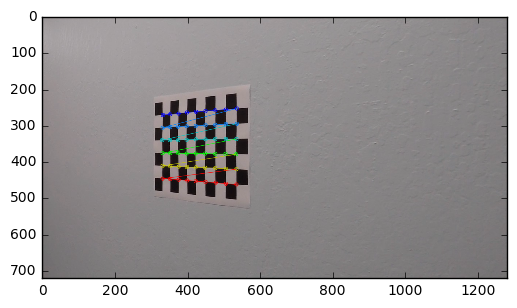

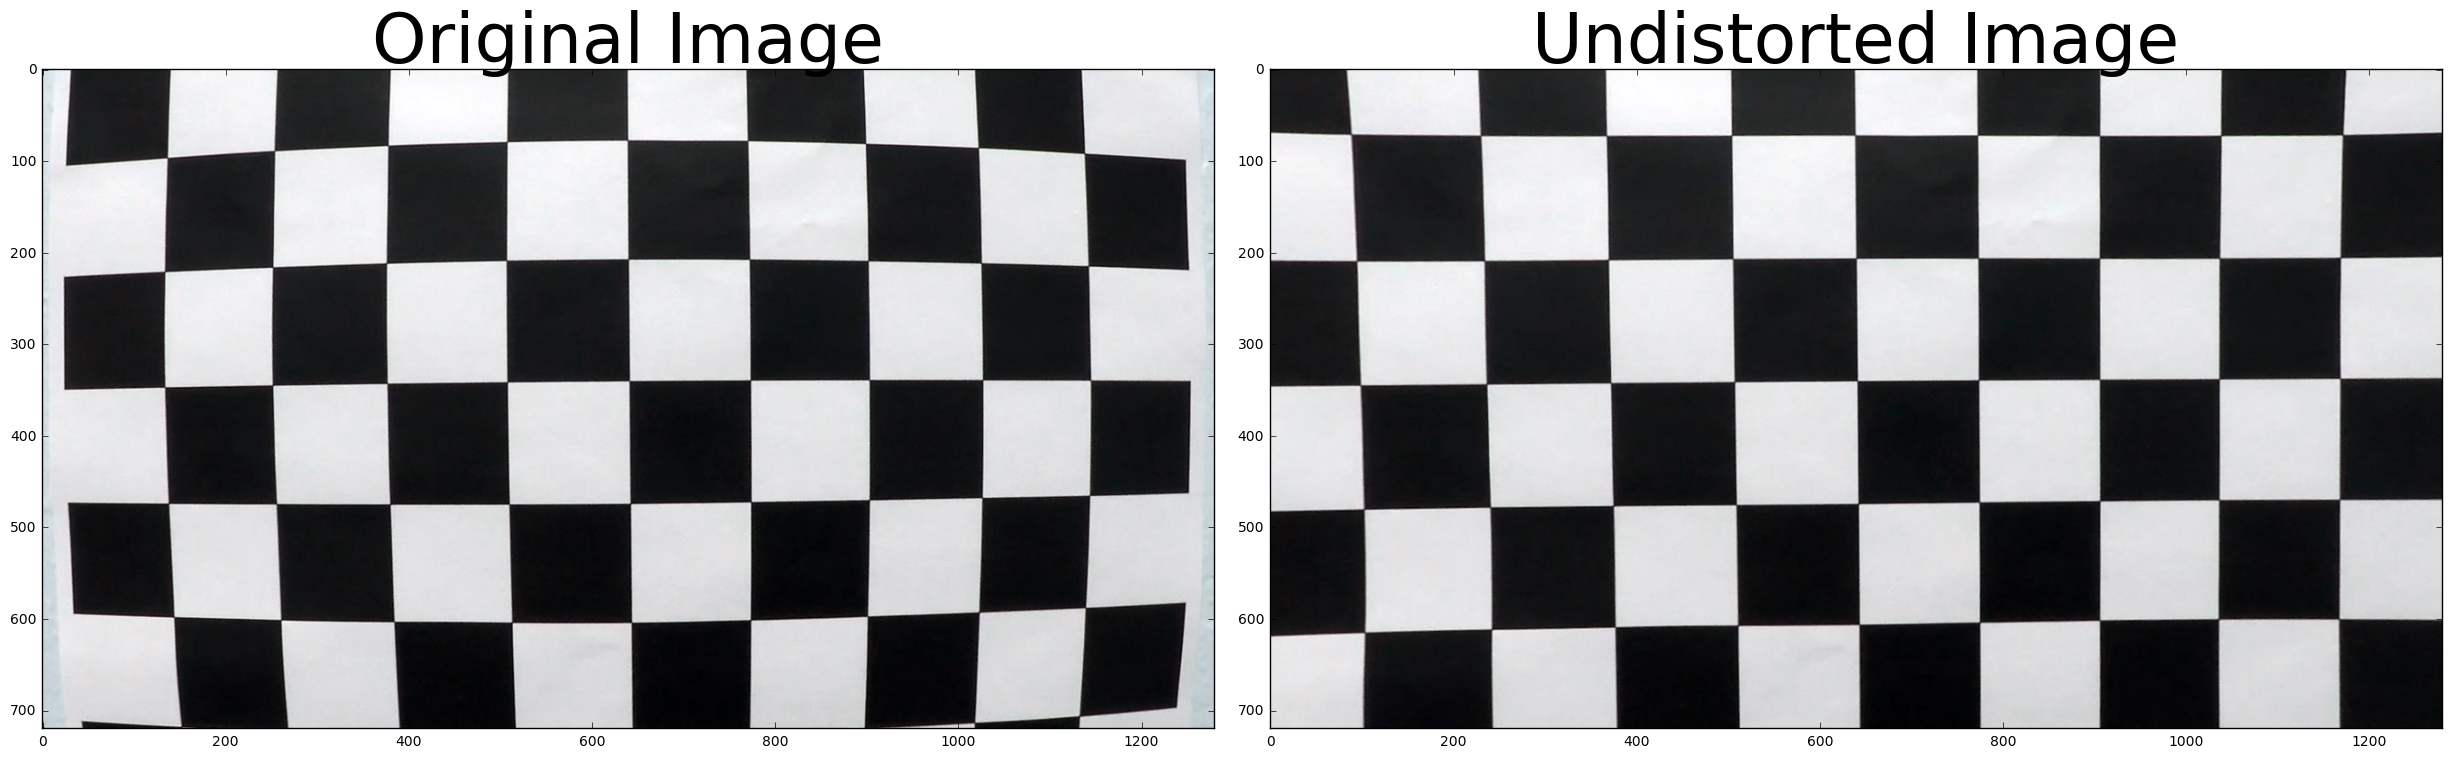

In [2]:
import glob
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

calibration_images_filenames = glob.glob('../CarND-Advanced-Lane-Lines/camera_cal/calibration*.jpg')
test_image_filename = '../CarND-Advanced-Lane-Lines/camera_cal/calibration1.jpg'
show_corners_image_filename = '../CarND-Advanced-Lane-Lines/camera_cal/calibration7.jpg'
calibration_images_filenames.remove(test_image_filename)

inside_corners_count_x = 9
inside_corners_count_y = 6

objp = np.zeros((inside_corners_count_x * inside_corners_count_y, 3), np.float32)
objp[:,:2] = np.mgrid[0:inside_corners_count_x, 0:inside_corners_count_y].T.reshape(-1,2)

corners_res = []
objp_res = []

detection_failed_count = 0

for calibration_image_filename in calibration_images_filenames:
    img = cv2.imread(calibration_image_filename)
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    ret, corners = cv2.findChessboardCorners(gray_img, (inside_corners_count_x, inside_corners_count_y), None)
    
    if ret:
        corners_res.append(corners)
        objp_res.append(objp)
    else:
        print('Chessboard corner detection failed:', calibration_image_filename)
            
    if show_corners_image_filename == calibration_image_filename:
        img_corners = cv2.drawChessboardCorners(img, (inside_corners_count_x, inside_corners_count_y), corners, ret)
        plt.imshow(img_corners)

test_img = cv2.imread(test_image_filename)
        
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objp_res, corners_res, test_img.shape[0:2], None, None)

undistorted_img = cv2.undistort(test_img, mtx, dist, None, mtx)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(test_img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted_img)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# Binay Image

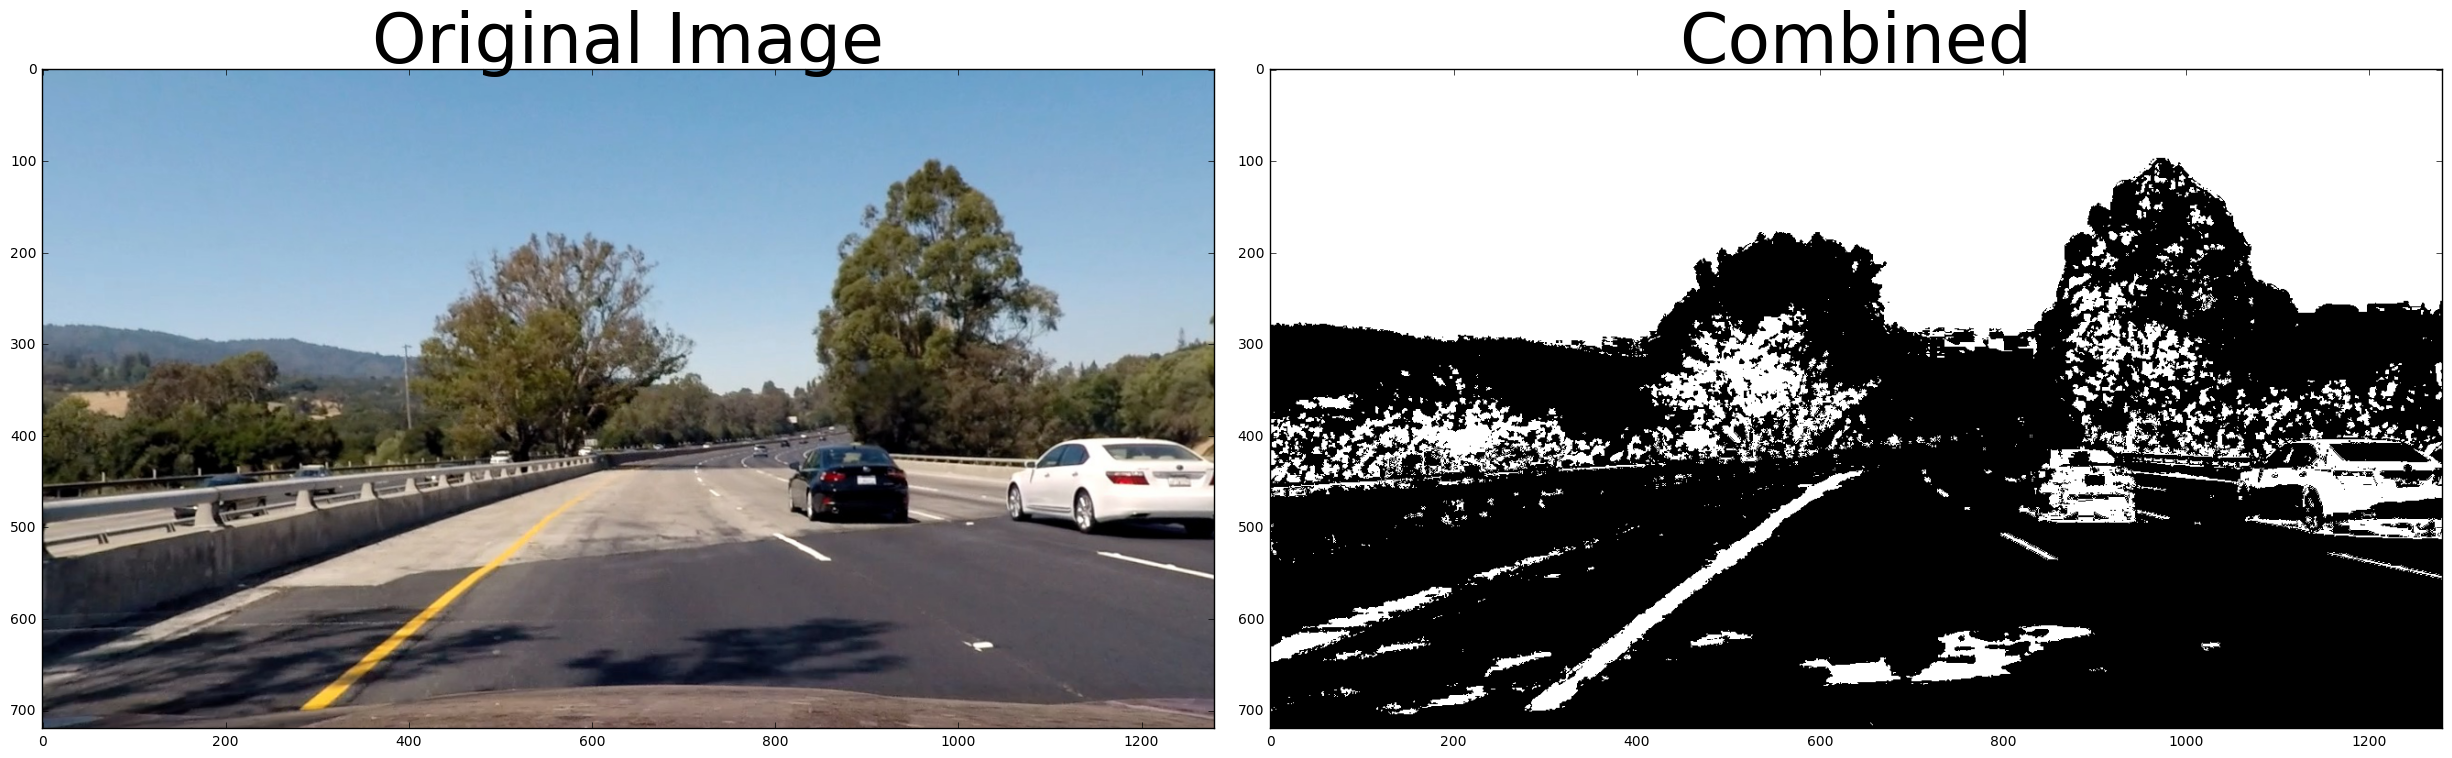

In [42]:
def abs_sobel_thresh(gray, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Calculate directional gradient
    # Apply threshold
    
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    else:
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    # 3) Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # 5) Create a mask of 1's where the scaled gradient magnitude
    # is > thresh_min and < thresh_max
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return sxbinary

def mag_thresh(gray, sobel_kernel=3, mag_thresh=(0, 255)):
    # Calculate gradient magnitude
    # Apply threshold
    
    # 2) Take the gradient in x and y separately
    sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Calculate the magnitude
    magnitude = np.sqrt(pow(sobel_x, 2) + pow(sobel_y, 2))
    # 5) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobel = np.uint8(255*magnitude/np.max(magnitude))
    # 6) Create a binary mask where mag thresholds are met
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1
    # 7) Return this mask as your binary_output image
    return sxbinary

def dir_threshold(gray, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Calculate gradient direction
    # Apply threshold
    
    # 2) Take the gradient in x and y separately
    sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Take the absolute value of the x and y gradients
    abs_sobelx = np.absolute(sobel_x)
    abs_sobely = np.absolute(sobel_y)
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient
    direction = np.arctan2(abs_sobely, abs_sobelx)
    # 5) Create a binary mask where direction thresholds are met
    sxbinary = np.zeros_like(direction)
    sxbinary[(direction >= thresh[0]) & (direction <= thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return sxbinary

def hls_select(S, thresh=(0, 255)):    
    # 2) Apply a threshold to the S channel
    binary_output = np.zeros_like(S)
    binary_output[(S > thresh[0]) & (S <= thresh[1])] = 1
    # 3) Return a binary image of threshold result
    return binary_output
    
# Read in an image
raw_test_image = mpimg.imread('../CarND-Advanced-Lane-Lines/test_images/test4.jpg')
image = cv2.undistort(raw_test_image, mtx, dist, None, mtx)

hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
S = hls[:,:,2]

# Choose a Sobel kernel size
ksize = 3 # Choose a larger odd number to smooth gradient measurements

# Apply each of the thresholding functions
gradx = abs_sobel_thresh(S, orient='x', sobel_kernel=ksize, thresh=(20, 100))
grady = abs_sobel_thresh(S, orient='y', sobel_kernel=ksize, thresh=(20, 100))
mag_binary = mag_thresh(S, sobel_kernel=ksize, mag_thresh=(30, 100))
dir_binary = dir_threshold(S, sobel_kernel=ksize, thresh=(0.7, 1.3))
hls_binary = hls_select(S, thresh=(90, 255))

combined = np.zeros_like(dir_binary)
combined[(((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))) | (hls_binary == 1)] = 1

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(combined, cmap='gray')
ax2.set_title('Combined', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)